#**Ma513 Project | Hands-On Machine Learning for Cybersecurity**
# Named Entity Recognition (NER) for Cybersecurity-Related Entities in Text

Group 16 | Alicia HEDDADJ - Aliyah PARFAIT | CDI

---

This notebook contains the implementation of a Named Entity Recognition (NER) system designed for the cybersecurity domain.
The objective is to identify and classify domain-specific entities (e.g. malware names, attacks, threats actors) from technical documents by identifying their tags in the IOB2 convention.

Key steps in the code will be data preparation (exploration, preprocessing), model development and analysis of its performance.

# 1.Data Exploration

We start by importing the necessary librairies. <br>
We also import the datasets directly from the [professor's github repository](https://github.com/AtillaKaanAlkan/NER4Cyber-IPSA). It is important that we first explore and visualize the data to see how we can approach its preprocessing and make it more efficient.


## Loading libraries & data

In [1]:
!pip install jsonlines

In [2]:
# Librairies
from google.colab import files
import os
import json
import jsonlines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Cloning data repository
!git clone https://github.com/AtillaKaanAlkan/NER4Cyber-IPSA.git

Cloning into 'NER4Cyber-IPSA'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 39 (delta 5), reused 23 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 1.03 MiB | 18.76 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [4]:
# Navigating to the data folder
data_path = "./NER4Cyber-IPSA/data"

# Also creating paths to each file
training_path = data_path + '/NER-TRAINING.jsonlines'
validation_path = data_path + '/NER-VALIDATION.jsonlines'
testing_path = data_path + '/NER-TESTING.jsonlines'

# Verifying the files in the data folder
print("Files in data folder:", os.listdir(data_path))

Files in data folder: ['NER-VALIDATION.jsonlines', 'NER-TESTING.jsonlines', 'NER-TRAINING.jsonlines']


In [5]:
# Understanding the datas
def load_and_preview_data(path, dataset_name, preview=True, preview_samples=2):
    """ Load and previews data """
    with open(path, 'r') as f:
        data = [json.loads(line) for line in f]

    if preview == True:
        # Print summary
        print(f"\nNumber of {dataset_name} samples: {len(data)}")
        print(f"\nFirst {preview_samples} samples from {dataset_name}:")
        for i, sample in enumerate(data[:preview_samples]):
            print(f"Sample {i+1}: {sample}")

    return data

# Loading and previewing each datasets
training_data = load_and_preview_data(training_path, "training")
validation_data = load_and_preview_data(validation_path, "validation")
testing_data = load_and_preview_data(testing_path, "testing")


Number of training samples: 4876

First 2 samples from training:
Sample 1: {'unique_id': 6506, 'tokens': ['Later', 'in', 'May', 'of', '2010', 'within', 'a', 'Pakistani', 'Senate', 'question', 'and', 'answer', 'session', ',', 'the', 'Gulshan-e-Jinnah', 'Complex', 'was', 'cited', 'under', 'Federal', 'Lodges', '/', 'Hostels', 'in', 'Islamabad', 'under', 'the', 'control', 'of', 'Pakistan', 'Ministry', 'for', 'Housing', 'and', 'Works', '.'], 'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}
Sample 2: {'unique_id': 5221, 'tokens': ['In', '2008', ',', 'Tom', 'Donahue', ',', 'a', 'senior', 'Central', 'Intelligence', 'Agency', '(', 'CIA', ')', 'official', 'told', 'a', 'meeting', 'of', 'utility', 'company', 'representatives', 'that', 'cyberattacks', 'had', 'taken', 'out', 'power', 'equipment', 'in', 'multiple', 'cities', 'outside', 'the', 'United',

As expected, our data is structured in the IOB2 format (Inside-Outside-Beginning), where each token in the dataset is assigned a tag indicating its role. <br>
The 'tokens' field contains the text tokens, while the 'ner_tags' field provides their corresponding labels. In the training and validation datasets, ner_tags are fully annotated, while the testing dataset does not include ner_tags yet, as these will need to be predicted by the model during evaluation.

## Visualizing data

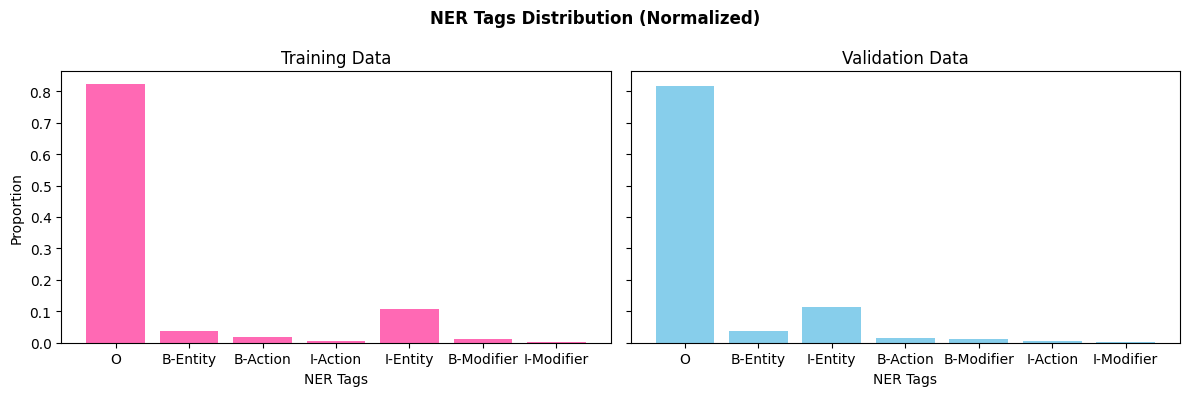

Tag distribution in training data (proportion):
 {'O': 0.822323618711083, 'B-Entity': 0.03636550765905621, 'B-Action': 0.017059196871194057, 'I-Action': 0.004442767209290358, 'I-Entity': 0.1084446884059214, 'B-Modifier': 0.0105151208466988, 'I-Modifier': 0.0008491002967562654}
Tag distribution in validation data (proportion):
 {'O': 0.816744039656936, 'B-Entity': 0.036312849162011177, 'I-Entity': 0.11436777087103628, 'B-Action': 0.01636635455189236, 'B-Modifier': 0.011015815563773703, 'I-Action': 0.004327641828625384, 'I-Modifier': 0.0008655283657250767}


In [6]:
# Exploring the data further

# Tag distribution for training data
all_tags_train = [tag for sample in training_data for tag in sample['ner_tags']]
tag_counts_train = Counter(all_tags_train)
total_tags_train = sum(tag_counts_train.values())
train_distribution = {tag: count / total_tags_train for tag, count in tag_counts_train.items()} # Normalizing to get %

# Tag distribution for validation data
all_tags_validation = [tag for sample in validation_data for tag in sample['ner_tags']]
tag_counts_validation = Counter(all_tags_validation)
total_tags_validation = sum(tag_counts_validation.values())
validation_distribution = {tag: count / total_tags_validation for tag, count in tag_counts_validation.items()} # Normalizing to get %

# Plotting side-by-side bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plt.suptitle("NER Tags Distribution (Normalized)", fontweight="bold")
# Training Data Plot
ax1.bar(train_distribution.keys(), train_distribution.values(), color='hotpink')
ax1.set_title("Training Data")
ax1.set_xlabel("NER Tags")
ax1.set_ylabel("Proportion")
# Validation Data Plot
ax2.bar(validation_distribution.keys(), validation_distribution.values(), color='skyblue')
ax2.set_title("Validation Data")
ax2.set_xlabel("NER Tags")

plt.tight_layout()
plt.show()

# Printing exact distribution values
print("Tag distribution in training data (proportion):\n", train_distribution)
print("Tag distribution in validation data (proportion):\n", validation_distribution)

This visualization highlights the similar characteristics of the NER tag distribution in both the training and validation datasets. The similarity between the datasets is a positive indication of consistency : if the validation set reflects the training data, it will make it more suitable for evaluating the model's performance.

Across these datasets, we can see that there are seven unique tags representing entities, actions, and modifiers, including the **O** tag, which signifies tokens outside any named entity or action. The tags include **B-Entity and I-Entity** (beginning and inside entities), **B-Action and I-Action** (beginning and inside actions), as well as **B-Modifier and I-Modifier** (beginning and inside modifiers).

An observation we can especially make is the overwhelming presence of the O tag : it accounts for more than 80% of the labels in both datasets, indicating that most tokens are not in zones of interest. This introduces a class imbalance issue that could impact the model's performance because if we ignore this problem, the model may overly predict the O tag to minimize errors but will fail to capture the smaller, more meaningful classes like B- or I-Entity.

Since this class imbalance cannot be ignored, we need to use proper techniques during the preprocessing of the data. For example, maybe we can help balance the learning process and ensure that the model does not bias its predictions toward the most frequent class by removing the tokens tagged O that are surrounded by O tag themselves, meaning that the whole zone is of no interest. <br>
Additionally, we can rely on the F1-score as an evaluation metric rather than on the accuracy alone, as it will provide a clearer picture of the model's ability to identify the underrepresented tags.

# 2.Pre-processing data

This next part focuses on preparing the data for a better performance of the model. As we've just seen, we will need to filter ou some 'O' tags to try and rebalance the classes distibution before extracting features.

## Filtering 'O' tags

In [7]:
# Filtering function : Removes 'O' tags that are surrounded by other 'O's
def filter_o_tags(tokens, ner_tags):
    filtered_tokens = []
    filtered_ner_tags = []

    for i, (token, tag) in enumerate(zip(tokens, ner_tags)):
        if tag == "O" and (i == 0 or ner_tags[i-1] == "O") and (i == len(tokens)-1 or ner_tags[i+1] == "O") :
            continue
        else:
            filtered_tokens.append(token)
            filtered_ner_tags.append(tag)

    return filtered_tokens, filtered_ner_tags

# Creating a filtered training dataset
def create_filtered_dataset(dataset):
    filtered_dataset = []
    for sample in dataset:
        filtered_tokens, filtered_ner_tags = filter_o_tags(sample['tokens'], sample['ner_tags'])
        filtered_dataset.append({
            'unique_id': sample['unique_id'],
            'tokens': filtered_tokens,
            'ner_tags': filtered_ner_tags
        })
    return filtered_dataset

# Applying the function to the training dataset
filtered_training_data = create_filtered_dataset(training_data)

# Saving for later
with jsonlines.open("NER_FILTERED_TRAINING.jsonl", mode='w') as writer:
    writer.write_all(filtered_training_data)
print("NER_FILTERED_TRAINING.jsonl file created successfully")

NER_FILTERED_TRAINING.jsonl file created successfully


## Extracting features

We can now build a function to extract each token features, as well as their surrounding's features (context).

In [8]:
def extract_features_with_context(data, context_size=0, is_test=False):
    all_features = []
    all_tags = [] if not is_test else None  # Test data has no tags

    for sample in data:
        tokens = sample['tokens']
        ner_tags = sample.get('ner_tags', [])  # Default to empty if 'ner_tags' is not present

        for i, token in enumerate(tokens):
            # Base features for the current token
            features = {
                "length": len(token),
                "is_upper": token.isupper(),
                "is_title": token.istitle(),
                "has_digits": any(char.isdigit() for char in token),
                "has_special_chars": any(not char.isalnum() for char in token),
            }

            # Add context (previous and next tokens based on context size)
            for offset in range(1, context_size + 1):
                # Previous token features
                if i - offset >= 0:
                    prev_token = tokens[i - offset]
                    features.update({
                        f"prev_{offset}_length": len(prev_token),
                        f"prev_{offset}_is_upper": prev_token.isupper(),
                        f"prev_{offset}_is_title": prev_token.istitle(),
                        f"prev_{offset}_has_digits": any(char.isdigit() for char in prev_token),
                        f"prev_{offset}_has_special_chars": any(not char.isalnum() for char in prev_token),
                    })
                else:
                    features.update({
                        f"prev_{offset}_length": 0,
                        f"prev_{offset}_is_upper": False,
                        f"prev_{offset}_is_title": False,
                        f"prev_{offset}_has_digits": False,
                        f"prev_{offset}_has_special_chars": False,
                    })

                # Next token features
                if i + offset < len(tokens):
                    next_token = tokens[i + offset]
                    features.update({
                        f"next_{offset}_length": len(next_token),
                        f"next_{offset}_is_upper": next_token.isupper(),
                        f"next_{offset}_is_title": next_token.istitle(),
                        f"next_{offset}_has_digits": any(char.isdigit() for char in next_token),
                        f"next_{offset}_has_special_chars": any(not char.isalnum() for char in next_token),
                    })
                else:
                    features.update({
                        f"next_{offset}_length": 0,
                        f"next_{offset}_is_upper": False,
                        f"next_{offset}_is_title": False,
                        f"next_{offset}_has_digits": False,
                        f"next_{offset}_has_special_chars": False,
                    })

            all_features.append(features)
            if not is_test:
                all_tags.append(ner_tags[i])

    return (pd.DataFrame(all_features), all_tags) if not is_test else pd.DataFrame(all_features)

# 3.Model Development

Our approach to developing a NER model was to explore basic algorithms we had already seen in class before focusing on more advanced transformer-based models.

## Exporting data for MATLAB




In [9]:
# RUNNING THIS IS OPTIONAL
# Loading data
training_data = load_and_preview_data(training_path, "training", False)
validation_data = load_and_preview_data(validation_path, "validation", False)
testing_data = load_and_preview_data(testing_path, "testing", False)
filtered_data = load_and_preview_data("/content/NER_FILTERED_TRAINING.jsonl", "filtered training", False)

context_size = 1

# Extracting features and labels
train_features, train_labels = extract_features_with_context(training_data, context_size=context_size)
filtered_features, filtered_labels = extract_features_with_context(filtered_data, context_size=context_size)

# Adding the labels as a column to the feature DataFrames
train_features['label'] = train_labels
filtered_features['label'] = filtered_labels

# Saving the DataFrames to CSV
train_features.to_csv('/content/training_data.csv', index=False)
filtered_features.to_csv('/content/filtered_training_data.csv', index=False)

print("Data successfully saved as CSV files :)")


Data successfully saved as CSV files :)


Once this code has been executed, we simply need to download the files and import them on Matlab. If a model seems promising, we can then export it back to the workspace. For instance, if we see that a tree classifier is efficient, exporting it would allow us to obtain its rules, which we could transpose in python (though maybe this is cheating a little bit?). Either way, the results were quite ineffective.

In [ ]:
# IF YOU WISH TO TRY OUT THIS CODE, THE CELL NEED TO BE MOVED DOWNWARD (JUST ONCE IS ENOUGH)
def decision_tree_predict(features):
    # Node 1
    if features["length"] < 5.5:
        # Node 2
        if not features["is_upper"]:
            # Node 4
            return "O"
        else:
            # Node 5
            if features["length"] < 4.5:
                # Node 8
                if not features["has_special_chars"]:
                    # Node 12
                    return "O"
                else:
                    # Node 13
                    if not features["is_title"]:
                        # Node 18
                        if features["length"] < 3.5:
                            # Node 24
                            return "I-Entity"
                        else:
                            # Node 25
                            return "O"
                    else:
                        # Node 19
                        return "O"
            else:
                # Node 9
                return "O"
    else:
        # Node 3
        if not features["is_title"]:
            # Node 6
            if not features["has_special_chars"]:
                # Node 10
                if features["length"] < 9.5:
                    # Node 14
                    return "O"
                else:
                    # Node 15
                    if not features["has_digits"]:
                        # Node 20
                        if not features["is_upper"]:
                            # Node 26
                            return "O"
                        else:
                            # Node 27
                            if features["length"] < 13.5:
                                # Node 30
                                return "O"
                            else:
                                # Node 31
                                return "I-Entity"
                    else:
                        # Node 21
                        if features["length"] < 35.5:
                            # Node 28
                            if features["length"] < 21:
                                # Node 32
                                return "O"
                            else:
                                # Node 33
                                if features["length"] < 23:
                                    # Node 34
                                    return "B-Entity"
                                else:
                                    # Node 35
                                    return "O"
                        else:
                            # Node 29
                            return "O"
            else:
                # Node 11
                if features["length"] < 20.5:
                    # Node 16
                    return "O"
                else:
                    # Node 17
                    if features["length"] < 45.5:
                        # Node 22
                        return "O"
                    else:
                        # Node 23
                        return "I-Entity"
        else:
            # Node 7
            return "O"

    return "O"  # Default case if no rules match


def apply_decision_tree(data, feature_extractor, context_size=0):
    predictions = []

    for sample in data:
        tokens = sample['tokens']
        features_df = feature_extractor([sample], context_size, is_test=True)
        sample_predictions = [
            decision_tree_predict(row.to_dict()) for _, row in features_df.iterrows()
        ]
        predictions.append(sample_predictions)  # ! Group predictions by sample

    return predictions


# Using it to make predictions
predictions = apply_decision_tree(
    data=validation_data,
    feature_extractor=extract_features_with_context,
    context_size=0
)

# Save predictions for the testing dataset
output_path = "decision_tree_test_predictions.jsonlines"
save_predictions(validation_data, predictions, output_path)
print(f"Predictions saved to {output_path}")

for i, sample in enumerate(validation_data):
    num_tokens = len(sample['tokens'])
    num_predictions = len(predictions[i])
    if num_tokens != num_predictions:
        print(f"Mismatch in sample {i}: {num_tokens} tokens, {num_predictions} predictions.")


## Tree classifiers

### Fine Tree

In [10]:
# Defining methods with different configurations
methods = [
    {"name": "method_1", "context_size": 0, "filter_o": False},
    {"name": "method_2", "context_size": 5, "filter_o": False},
    {"name": "method_3", "context_size": 8, "filter_o": False},
    {"name": "method_4", "context_size": 0, "filter_o": True},
    {"name": "method_5", "context_size": 5, "filter_o": True},
    {"name": "method_6", "context_size": 8, "filter_o": True},
]

# Datasets
training_data = load_and_preview_data(training_path, "training", False)
validation_data = load_and_preview_data(validation_path, "validation", False)
testing_data = load_and_preview_data(testing_path, "testing", False)
filtered_data = load_and_preview_data("/content/NER_FILTERED_TRAINING.jsonl", "filtered training", False)

# Function to save predictions as JSONL
def save_predictions(data, predictions, output_path):
    with open(output_path, 'w') as f:
        for sample, pred_tags in zip(data, predictions):
            sample['ner_tags'] = pred_tags
            f.write(json.dumps(sample) + '\n')

# Directory to save prediction outputs
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

# Train and predict using all methods
for method in methods:
    print(f"Processing {method['name']}...")

    # Apply filter if required
    if method["filter_o"]:
        training_data_to_use = filtered_data
    else:
        training_data_to_use = training_data

    # Feature extraction for training and validation
    X_train, y_train = extract_features_with_context(training_data_to_use, method["context_size"])
    X_val, y_val = extract_features_with_context(validation_data, method["context_size"])

    # Train the classifier
    classifier = DecisionTreeClassifier(max_depth=20, random_state=16)

    classifier.fit(X_train, y_train)

    # Predict on validation data
    val_predictions = classifier.predict(X_val)

    # Calculate precision, recall, and F1 score for validation
    report = classification_report(y_val, val_predictions, zero_division=0)
    print(f"Validation Classification Report for {method['name']}:\n{report}")

    # Predict on test data
    X_validation = extract_features_with_context(validation_data, method["context_size"], is_test=True)
    test_predictions = classifier.predict(X_validation)

    # Save predictions for each token (rather than the whole sample)
    test_pred_tags = []
    index = 0
    for sample in testing_data:
        tokens = sample['tokens']
        sample_preds = test_predictions[index:index + len(tokens)]
        test_pred_tags.append(sample_preds.tolist())  # Convert to list before appending
        index += len(tokens)

    # Save predictions
    output_path = os.path.join(output_dir, f"FineTree_{method['name']}_test_predictions.jsonlines")
    save_predictions(testing_data, test_pred_tags, output_path)
    print(f"Predictions saved to {output_path}")

    test_pred_tags = []
    index = 0
    for sample in validation_data:
        tokens = sample['tokens']
        sample_preds = test_predictions[index:index + len(tokens)]
        test_pred_tags.append(sample_preds.tolist())  # Convert to list before appending
        index += len(tokens)

    # Save predictions
    output_path = os.path.join(output_dir, f"FineTree_{method['name']}_val_predictions.jsonlines")
    save_predictions(validation_data, test_pred_tags, output_path)
    print(f"Predictions saved to {output_path}")

Processing method_1...
Validation Classification Report for method_1:
              precision    recall  f1-score   support

    B-Action       0.00      0.00      0.00       416
    B-Entity       0.00      0.00      0.00       923
  B-Modifier       0.00      0.00      0.00       280
    I-Action       0.00      0.00      0.00       110
    I-Entity       0.42      0.01      0.01      2907
  I-Modifier       0.00      0.00      0.00        22
           O       0.82      1.00      0.90     20760

    accuracy                           0.82     25418
   macro avg       0.18      0.14      0.13     25418
weighted avg       0.72      0.82      0.74     25418

Predictions saved to predictions/FineTree_method_1_test_predictions.jsonlines
Predictions saved to predictions/FineTree_method_1_val_predictions.jsonlines
Processing method_2...
Validation Classification Report for method_2:
              precision    recall  f1-score   support

    B-Action       0.00      0.00      0.00         0

### Random Forest

In [11]:
# Defining methods with different configurations
methods = [
    {"name": "method_1", "context_size": 0, "filter_o": True},
    {"name": "method_2", "context_size": 5, "filter_o": True},
    {"name": "method_3", "context_size": 8, "filter_o": True},
]

# Datasets
training_data = load_and_preview_data(training_path, "training", False)
validation_data = load_and_preview_data(validation_path, "validation", False)
testing_data = load_and_preview_data(testing_path, "testing", False)
filtered_data = load_and_preview_data("/content/NER_FILTERED_TRAINING.jsonl", "filtered training", False)

# Function to save predictions as JSONL
def save_predictions(data, predictions, output_path):
    with open(output_path, 'w') as f:
        for sample, pred_tags in zip(data, predictions):
            sample['ner_tags'] = pred_tags
            f.write(json.dumps(sample) + '\n')

# Directory to save prediction outputs
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

# Train and predict using all methods
for method in methods:
    print(f"Processing {method['name']}...")

    # Apply filter if required
    if method["filter_o"]:
        training_data_to_use = filtered_data
    else:
        training_data_to_use = training_data

    # Feature extraction for training and validation
    X_train, y_train = extract_features_with_context(training_data_to_use, method["context_size"])
    X_val, y_val = extract_features_with_context(validation_data, method["context_size"])

    # Train the classifier
    classifier = RandomForestClassifier(
    n_estimators=100,          # Number of trees
    max_depth=20,              # Maximum depth of the trees
    random_state=16,           # Ensure reproducibility
    class_weight='balanced',   # Handle class imbalance
    n_jobs=-1,                 # Use all CPU cores for faster training
    max_features='sqrt'        # Use sqrt(number of features) for splitting (recommended)
    )

    classifier.fit(X_train, y_train)

    # Predict on validation data
    val_predictions = classifier.predict(X_val)

    # Predict on test data
    X_validation = extract_features_with_context(validation_data, method["context_size"], is_test=True)
    test_predictions = classifier.predict(X_validation)

    # Save predictions for each token (rather than the whole sample)
    test_pred_tags = []
    index = 0
    for sample in testing_data:
        tokens = sample['tokens']
        sample_preds = test_predictions[index:index + len(tokens)]
        test_pred_tags.append(sample_preds.tolist())  # Convert to list before appending
        index += len(tokens)

    # Save predictions
    output_path = os.path.join(output_dir, f"RF_{method['name']}_test_predictions.jsonlines")
    save_predictions(testing_data, test_pred_tags, output_path)
    print(f"Predictions saved to {output_path}")

    test_pred_tags = []
    index = 0
    for sample in validation_data:
        tokens = sample['tokens']
        sample_preds = test_predictions[index:index + len(tokens)]
        test_pred_tags.append(sample_preds.tolist())  # Convert to list before appending
        index += len(tokens)

    # Save predictions
    output_path = os.path.join(output_dir, f"RF_{method['name']}_val_predictions.jsonlines")
    save_predictions(validation_data, test_pred_tags, output_path)
    print(f"Predictions saved to {output_path}")

Processing method_1...
Predictions saved to predictions/RF_method_1_test_predictions.jsonlines
Predictions saved to predictions/RF_method_1_val_predictions.jsonlines
Processing method_2...
Predictions saved to predictions/RF_method_2_test_predictions.jsonlines
Predictions saved to predictions/RF_method_2_val_predictions.jsonlines
Processing method_3...
Predictions saved to predictions/RF_method_3_test_predictions.jsonlines
Predictions saved to predictions/RF_method_3_val_predictions.jsonlines


### LightGBM

In [68]:
# Defining methods with different configurations
methods = [
    {"name": "method_1", "context_size": 5, "filter_o": True},
]

# Datasets
training_data = load_and_preview_data(training_path, "training", False)
validation_data = load_and_preview_data(validation_path, "validation", False)
testing_data = load_and_preview_data(testing_path, "testing", False)
filtered_data = load_and_preview_data("/content/NER_FILTERED_TRAINING.jsonl", "filtered training", False)

# Function to save predictions as JSONL
def save_predictions(data, predictions, output_path):
    with open(output_path, 'w') as f:
        for sample, pred_tags in zip(data, predictions):
            sample['ner_tags'] = pred_tags
            f.write(json.dumps(sample) + '\n')

# Directory to save prediction outputs
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

# Train and predict using all methods
for method in methods:
    print(f"Processing {method['name']}...")

    # Apply filter if required
    if method["filter_o"]:
        training_data_to_use = filtered_data
    else:
        training_data_to_use = training_data

    # Feature extraction for training and validation
    X_train, y_train = extract_features_with_context(training_data_to_use, method["context_size"])
    X_val, y_val = extract_features_with_context(validation_data, method["context_size"])

    # Train the classifier
    classifier = LGBMClassifier(
        n_estimators=250,
        max_depth=15,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=16,
    )

    classifier.fit(X_train, y_train)

    # Save the model after training
    model_path = "/content/LGBM_model.txt"
    classifier.booster_.save_model(model_path)
    print(f"Model saved to {model_path}")

    # Predict on validation data
    val_predictions = classifier.predict(X_val)

    # Predict on test data
    X_validation = extract_features_with_context(validation_data, method["context_size"], is_test=True)
    test_predictions = classifier.predict(X_validation)

    # Save predictions for each token (rather than the whole sample)
    test_pred_tags = []
    index = 0
    for sample in testing_data:
        tokens = sample['tokens']
        sample_preds = test_predictions[index:index + len(tokens)]
        test_pred_tags.append(sample_preds.tolist())  # Convert to list before appending
        index += len(tokens)

    # Save predictions
    output_path = os.path.join(output_dir, f"LGBM_est250_test_predictions.jsonlines")
    save_predictions(testing_data, test_pred_tags, output_path)
    print(f"Predictions saved to {output_path}")

    test_pred_tags = []
    index = 0
    for sample in validation_data:
        tokens = sample['tokens']
        sample_preds = test_predictions[index:index + len(tokens)]
        test_pred_tags.append(sample_preds.tolist())  # Convert to list before appending
        index += len(tokens)

    # Save predictions
    output_path = os.path.join(output_dir, f"LGBM_est250_val_predictions.jsonlines")
    save_predictions(validation_data, test_pred_tags, output_path)
    print(f"Predictions saved to {output_path}")

Processing method_1...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 25054, number of used features: 55
[LightGBM] [Info] Start training from score -2.533401
[LightGBM] [Info] Start training from score -1.776470
[LightGBM] [Info] Start training from score -3.017277
[LightGBM] [Info] Start training from score -3.878814
[LightGBM] [Info] Start training from score -0.683851
[LightGBM] [Info] Start training from score -5.533669
[LightGBM] [Info] Start training from score -1.753620
Model saved to /content/LGBM_model.txt
Predictions saved to predictions/LGBM_est250_test_predictions.jsonlines
Predictions saved to predictions/LGBM_est250_val_predictions.jsonlines


## Transformer-based : BERT

In [ ]:
!pip install transformers torch

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments, pipeline
from datasets import Dataset

# 1. Use a light pre-trained model
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=7,
    label2id={
        'O': 0,
        'B-Entity': 1,
        'B-Action': 2,
        'I-Action': 3,
        'I-Entity': 4,
        'B-Modifier': 5,
        'I-Modifier': 6
    },
    id2label={
        0: 'O',
        1: 'B-Entity',
        2: 'B-Action',
        3: 'I-Action',
        4: 'I-Entity',
        5: 'B-Modifier',
        6: 'I-Modifier'
    }
)

# 2. Load data
training_data = load_and_preview_data(training_path, "training", False)
validation_data = load_and_preview_data(validation_path, "validation", False)
testing_data = load_and_preview_data(testing_path, "testing", False)
filtered_data = load_and_preview_data("/content/NER_FILTERED_TRAINING.jsonl", "filtered training", False)

# 3. Tokenize and align labels
def tokenize_and_align_labels(data, is_test=False):
    tokens = [sample['tokens'] for sample in data]
    if not is_test:
        labels = [[model.config.label2id[label] for label in sample['ner_tags']] for sample in data]
    else:
        labels = [[-100] * len(sample['tokens']) for sample in data]  # Use -100 for test labels

    tokenized_inputs = tokenizer(tokens, padding=True, truncation=True, is_split_into_words=True)
    aligned_labels = []

    for i, label in enumerate(labels):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        aligned_labels.append(aligned)

    tokenized_inputs['labels'] = aligned_labels
    return tokenized_inputs


training_tokenized = tokenize_and_align_labels(training_data)
filtered_training_tokenized = tokenize_and_align_labels(filtered_data)
validation_tokenized = tokenize_and_align_labels(validation_data)
test_tokenized = tokenize_and_align_labels(testing_data, is_test=True)

# 4. Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict(training_tokenized)
filtered_train_dataset = Dataset.from_dict(filtered_training_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

# 5. Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-3,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    num_train_epochs=8,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

# 6. Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=filtered_train_dataset,
    eval_dataset=test_dataset
)

# 7. Train and save the model
trainer.train()
trainer.save_model("filtered_fine_tuned_bert_ner")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.286900,nan
2,1.390500,nan
3,1.286300,nan
4,1.223900,nan
5,1.354100,nan
6,1.311300,nan
7,1.283200,nan


Epoch,Training Loss,Validation Loss
1,1.286900,nan
2,1.390500,nan
3,1.286300,nan
4,1.223900,nan
5,1.354100,nan
6,1.311300,nan
7,1.283200,nan
8,1.508200,nan


In [63]:
# Applying model for predictions

model = BertForTokenClassification.from_pretrained("filtered_fine_tuned_bert_ner")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
token_classifier = pipeline("token-classification", model=model, tokenizer=tokenizer)

def predict_for_data(dataset):
    predictions = []

    for entry in dataset:
        # Construct the phrase from tokens, making sure to preserve spacing
        phrase = " ".join(entry['tokens'])

        # Use the classifier to predict tags for the phrase
        classification_results = token_classifier(phrase)

        # Initialize predicted tags as 'O' for every token
        predicted_tags = ["O"] * len(entry['tokens'])

        # Character-level tracking
        current_char_pos = 0

        # Process each token and match it to the predicted spans
        for idx, token in enumerate(entry['tokens']):
            # Find the start and end of the token in the phrase (after tokenization and joining)
            token_start = current_char_pos
            token_end = token_start + len(token)

            # Check if any prediction matches this token's span
            for prediction in classification_results:
                # Check if the prediction's span covers the token's span
                if prediction['start'] >= token_start and prediction['end'] <= token_end:
                    # Assign the predicted entity to the token
                    predicted_tags[idx] = prediction['entity']
                    break

            # Update the character position (the space after the token)
            current_char_pos = token_end + 1  # Add 1 to account for the space

        # Append the result
        predictions.append({
            'unique_id': entry['unique_id'],
            'tokens': entry['tokens'],
            'ner_tags': predicted_tags})

    return predictions


# PREDICTIONS ON TESTING DATA
predictions = predict_for_data(testing_data)
output_path = "/content/predictions/Fine_tuned_BERT_test_predictions.jsonlines"
with open(output_path, 'w') as f:
    for item in predictions:
        f.write(json.dumps(item) + "\n")

print(f"Predictions saved to {output_path}.")

# PREDICTIONS ON VALIDATION DATA
predictions = predict_for_data(validation_data)
output_path = "/content/predictions/Fine_tuned_BERT_val_predictions.jsonlines"
with open(output_path, 'w') as f:
    for item in predictions:
        f.write(json.dumps(item) + "\n")

print(f"Predictions saved to {output_path}.")

Device set to use cpu


Predictions saved to /content/predictions/Fine_tuned_BERT_test_predictions.jsonlines.
Predictions saved to /content/predictions/Fine_tuned_BERT_val_predictions.jsonlines.


In [ ]:
import torch
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments, pipeline
from datasets import Dataset

# 1. Use a light pre-trained model
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=7,
    label2id={
        'O': 0,
        'B-Entity': 1,
        'B-Action': 2,
        'I-Action': 3,
        'I-Entity': 4,
        'B-Modifier': 5,
        'I-Modifier': 6
    },
    id2label={
        0: 'O',
        1: 'B-Entity',
        2: 'B-Action',
        3: 'I-Action',
        4: 'I-Entity',
        5: 'B-Modifier',
        6: 'I-Modifier'
    }
)

# 2. Load data
training_data = load_and_preview_data(training_path, "training", False)
validation_data = load_and_preview_data(validation_path, "validation", False)
testing_data = load_and_preview_data(testing_path, "testing", False)
filtered_data = load_and_preview_data("/content/NER_FILTERED_TRAINING.jsonl", "filtered training", False)

# 3. Tokenize and align labels
def tokenize_and_align_with_features(data, is_test=False, context_size=0):
    features_df = extract_features_with_context(data, context_size)
    tokens = [sample['tokens'] for sample in data]

    labels = [[model.config.label2id[label] for label in sample['ner_tags']] for sample in data] if not is_test else []
    tokenized_inputs = tokenizer(tokens, padding=True, truncation=True, is_split_into_words=True)
    aligned_labels = []

    for i, label in enumerate(labels):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        aligned_labels.append(aligned)

    tokenized_inputs['labels'] = aligned_labels

    # Scale the features and add them to the tokenized inputs
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)
    tokenized_inputs['custom_features'] = scaled_features.tolist()

    return tokenized_inputs


training_tokenized = tokenize_and_align_labels(training_data)
filtered_training_tokenized = tokenize_and_align_labels(filtered_data)
validation_tokenized = tokenize_and_align_labels(validation_data)
test_tokenized = tokenize_and_align_labels(testing_data, is_test=True)

# 4. Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict(training_tokenized)
filtered_train_dataset = Dataset.from_dict(filtered_training_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

# 5. Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-3,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    num_train_epochs=8,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

# 6. Trainer setup
trainer2 = Trainer(
    model=model,
    args=training_args,
    train_dataset=filtered_train_dataset,
    eval_dataset=test_dataset
)

# 7. Train and save the model
trainer2.train()
trainer2.save_model("filtered_fine_tuned_bert_ner2")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.287700,nan
2,1.392900,nan
3,1.288200,nan
4,1.221700,nan
5,1.354400,nan
6,1.313500,nan
7,1.286300,nan
8,1.510000,nan


In [66]:
# Applying model for predictions

model = BertForTokenClassification.from_pretrained("filtered_fine_tuned_bert_ner2")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
token_classifier = pipeline("token-classification", model=model, tokenizer=tokenizer)

def predict_for_data(dataset):
    predictions = []

    for entry in dataset:
        # Construct the phrase from tokens, making sure to preserve spacing
        phrase = " ".join(entry['tokens'])

        # Use the classifier to predict tags for the phrase
        classification_results = token_classifier(phrase)

        # Initialize predicted tags as 'O' for every token
        predicted_tags = ["O"] * len(entry['tokens'])

        # Character-level tracking
        current_char_pos = 0

        # Process each token and match it to the predicted spans
        for idx, token in enumerate(entry['tokens']):
            # Find the start and end of the token in the phrase (after tokenization and joining)
            token_start = current_char_pos
            token_end = token_start + len(token)

            # Check if any prediction matches this token's span
            for prediction in classification_results:
                # Check if the prediction's span covers the token's span
                if prediction['start'] >= token_start and prediction['end'] <= token_end:
                    # Assign the predicted entity to the token
                    predicted_tags[idx] = prediction['entity']
                    break

            # Update the character position (the space after the token)
            current_char_pos = token_end + 1  # Add 1 to account for the space

        # Append the result
        predictions.append({
            'unique_id': entry['unique_id'],
            'tokens': entry['tokens'],
            'ner_tags': predicted_tags})

    return predictions


# PREDICTIONS ON TESTING DATA
predictions = predict_for_data(testing_data)
output_path = "/content/predictions/Fine_tuned_BERT_test_predictions2.jsonlines"
with open(output_path, 'w') as f:
    for item in predictions:
        f.write(json.dumps(item) + "\n")

print(f"Predictions saved to {output_path}.")

# PREDICTIONS ON VALIDATION DATA
predictions = predict_for_data(validation_data)
output_path = "/content/predictions/Fine_tuned_BERT_val_predictions2.jsonlines"
with open(output_path, 'w') as f:
    for item in predictions:
        f.write(json.dumps(item) + "\n")

print(f"Predictions saved to {output_path}.")

Device set to use cpu


Predictions saved to /content/predictions/Fine_tuned_BERT_test_predictions2.jsonlines.
Predictions saved to /content/predictions/Fine_tuned_BERT_val_predictions2.jsonlines.


# 4.Predictions Evaluation

We can now check that the predictions format is compatible with the actual dataset (no missing NER tag predictions etc.), before comparing the evaluation metrics to see how each model performs.

## Checking format mismatch

In [65]:
# Checking if the number of tokens matches the number of predicted NER tags

def check_tokens_and_predictions(predictions_path):

    with open(predictions_path, 'r') as f:
        predictions = [json.loads(line) for line in f]

    # Check each sample in the predictions
    for idx, sample in enumerate(predictions):
        tokens = sample['tokens']
        predicted_tags = sample['ner_tags']

        # Report if the number of tokens does not match the number of predicted tags
        if len(tokens) != len(predicted_tags):
            print(f"Mismatch in sample {idx}:")
            print(f"  Number of tokens: {len(tokens)}")
            print(f"  Number of predicted tags: {len(predicted_tags)}")
            print(f"  Tokens: {tokens}")
            print(f"  Predicted tags: {predicted_tags}")
    print("Done checking for mismatch!")

predictions_path = "/content/predictions/Fine_tuned_BERT_val_predictions.jsonlines"
check_tokens_and_predictions(predictions_path)

Done checking for mismatch!


## Checking evaluation scores

In [19]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=acf3bfa9a0dabd91c292eeec9bef3075a96f2bdaa6bc6f8bdafd4bc28dcbbbac
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [67]:
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from seqeval.scheme import IOB2
import numpy as np
import json

def pretty_print_dict(d, indent):
    res = ""
    for k, v in d.items():
        res += "\t"*indent + str(k) + "\n"
        if isinstance(v, dict):
            res += pretty_print_dict(v, indent+1)
        else:
            res += "\t"*(indent+1) + str(v) + "\n"
    print(res)
    return res

def compute_seqeval_jsonl(references_jsonl, predictions_jsonl, ref_col='ner_tags', pred_col='ner_tags'):
    '''
    Computes the seqeval scores between two datasets loaded from jsonl (list of dicts with same keys).
    Sorts the datasets by 'unique_id' and verifies that the tokens match.
    '''
    # extract the tags and reverse the dict
    ref_dict = {k:[e[k] for e in references_jsonl] for k in references_jsonl[0].keys()}
    pred_dict = {k:[e[k] for e in predictions_jsonl] for k in predictions_jsonl[0].keys()}

    # sort by unique_id
    ref_idx = np.argsort(ref_dict['unique_id'])
    pred_idx = np.argsort(pred_dict['unique_id'])
    ref_ner_tags = np.array(ref_dict[ref_col], dtype=object)[ref_idx]
    pred_ner_tags = np.array(pred_dict[pred_col], dtype=object)[pred_idx]
    ref_tokens = np.array(ref_dict['tokens'], dtype=object)[ref_idx]
    pred_tokens = np.array(pred_dict['tokens'], dtype=object)[pred_idx]

    # check that tokens match
    #assert((ref_tokens==pred_tokens).all())


    # get report
    report = classification_report(y_true=ref_ner_tags, y_pred=pred_ner_tags, scheme=IOB2, output_dict=True)

    # extract values we care about
    report.pop("macro avg")
    report.pop("weighted avg")
    overall_score = report.pop("micro avg")

    seqeval_results = {
        type_name: {
            "precision": score["precision"],
            "recall": score["recall"],
            "f1": score["f1-score"],
            "suport": score["support"],
        }
        for type_name, score in report.items()
    }
    seqeval_results["overall_precision"] = overall_score["precision"]
    seqeval_results["overall_recall"] = overall_score["recall"]
    seqeval_results["overall_f1"] = overall_score["f1-score"]
    seqeval_results["overall_accuracy"] = accuracy_score(y_true=ref_ner_tags, y_pred=pred_ner_tags)

    return(seqeval_results)


if __name__ == '__main__':

    # Pour les étudiants : indiquer le chemin vers le fichier NER-VALIDATION
    with open("/content/NER4Cyber-IPSA/data/NER-VALIDATION.jsonlines", 'r') as f:
        references_jsonl = [json.loads(l) for l in list(f)]

    # Pour les étudiants : indiquer ici le chemin vers votre fichier de prédiction sur le jeu de validation
    with open("/content/predictions/Fine_tuned_BERT_val_predictions2.jsonlines", 'r') as f:
        pred_jsonl = [json.loads(l) for l in list(f)]


    res = compute_seqeval_jsonl(references_jsonl, pred_jsonl, ref_col = 'ner_tags', pred_col='ner_tags')
    pretty_print_dict(res, 0)

	precision
		0.0
	recall
		0.0
	f1
		0.0
	suport
		416

	precision
		0.0
	recall
		0.0
	f1
		0.0
	suport
		923

	precision
		0.0
	recall
		0.0
	f1
		0.0
	suport
		280

Action
	precision
		0.0
	recall
		0.0
	f1
		0.0
	suport
		416
Entity
	precision
		0.0
	recall
		0.0
	f1
		0.0
	suport
		923
Modifier
	precision
		0.0
	recall
		0.0
	f1
		0.0
	suport
		280
overall_precision
	0.0
overall_recall
	0.0
overall_f1
	0.0
overall_accuracy
	0.11452513966480447

